In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib
from pvlib.location import Location
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
data=pd.read_csv('Bangalore_data.csv')
data.dropna(inplace=True)

In [20]:
data.columns

Index(['timestamp', 'temperature', 'humidity', 'wind_speed', 'wind_direction',
       'surface_pressure', 'cloud_cover', 'water_vapour', 'ghi', 'dni', 'dhi'],
      dtype='object')

In [18]:
data=data.rename(columns={'time':'timestamp','temperature_2m (°C)':'temperature','relative_humidity_2m (%)':'humidity','wind_speed_10m (km/h)':'wind_speed','wind_direction_10m (°)':'wind_direction','cloud_cover (%)':'cloud_cover',
                          'surface_pressure (hPa)':'surface_pressure','total_column_integrated_water_vapour (kg/m²)':'water_vapour','shortwave_radiation (W/m²)':'ghi','direct_normal_irradiance (W/m²)':'dni','diffuse_radiation (W/m²)':'dhi'})

data.to_csv('Bangalore_data.csv',index=False)

In [ ]:
data

,timestamp,temperature,humidity,wind_speed,wind_direction,surface_pressure,cloud_cover,water_vapour,ghi,dni,dhi
0,2014-01-01T00:00,16.8,86,13.0,92,916.5,84,14.2,0,0.0,0
1,2014-01-01T01:00,16.7,89,13.3,90,916.2,90,13.7,0,0.0,0
2,2014-01-01T02:00,16.3,91,12.3,87,915.7,95,13.3,0,0.0,0
3,2014-01-01T03:00,16.4,89,11.6,85,915.4,79,13.1,0,0.0,0
4,2014-01-01T04:00,16.3,89,11.3,81,915.3,74,13.3,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
100819,2025-12-31T19:00,25.0,52,2.5,159,913.9,100,25.5,0,0.0,0
100820,2025-12-31T20:00,24.2,56,5.0,109,914.1,100,25.2,0,0.0,0
100821,2025-12-31T21:00,23.0,62,4.3,185,914.8,100,26.3,0,0.0,0
100822,2025-12-31T22:00,22.3,66,5.6,245,914.8,78,27.4,0,0.0,0


In [ ]:
import pandas as pd
import numpy as np
import pvlib
from pvlib.location import Location

def add_solar_features_ist(df, lat, lon, altitude=0, tz='Asia/Kolkata'):
    """
    Adds solar position, cyclical time, and clear sky features in IST.
    """
    # 1. Convert to DatetimeIndex and localize to IST
    if not isinstance(df.index, pd.DatetimeIndex):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
    
    # Localize to IST (GMT+5:30)
    if df.index.tz is None:
        df.index = df.index.tz_localize(tz)
    else:
        df.index = df.index.tz_convert(tz)

    # 2. Define Location with the specific timezone
    site = Location(lat, lon, altitude=altitude, tz=tz)
    
    # 3. Solar Position
    solpos = site.get_solarposition(df.index)
    df['solar_zenith'] = solpos['apparent_zenith']
    df['cos_zenith'] = np.cos(np.radians(df['solar_zenith'])).clip(lower=0)

    # 4. Cyclical Time Features (using the local hour)
    # Using the local hour is critical for India's 5:30 offset
    local_hour = df.index.hour + df.index.minute / 60
    
    df['hour_sin'] = np.sin(2 * np.pi * local_hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * local_hour / 24)
    
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

    # 5. Clear Sky GHI
    clearsky = site.get_clearsky(df.index)
    df['clear_ghi'] = clearsky['ghi']
    df['kt']= df['ghi'] / df['clear_ghi']
    df['kt'] = df['kt'].fillna(0)
    df.replace([np.inf, -np.inf], 0, inplace=True)

    return df

# --- Usage for India ---

file_path = 'Bangalore_data.csv' # Replace with your actual filename
df_original = pd.read_csv(file_path)


# Coordinates for Bangalore (example)
LATITUDE = 12.9787698
LONGITUDE = 77.635832

df_merged = add_solar_features_ist(df_original, LATITUDE, LONGITUDE)

df_merged = df_merged.reset_index()

# Displaying results
df_merged.head(10)
df_merged.to_csv('Bangalore_data.csv', index=False)


# LSTM Training

In [51]:
df=pd.read_csv("Bangalore_data.csv")
df.describe()

,temperature,humidity,wind_speed,wind_direction,surface_pressure,cloud_cover,water_vapour,ghi,dni,dhi,solar_zenith,cos_zenith,hour_sin,hour_cos,day_sin,day_cos,clear_ghi,kt
count,100824.000000,100824.000000,100824.000000,100824.000000,100824.000000,100824.000000,100824.000000,100824.000000,100824.000000,100824.000000,100824.000000,100824.000000,1.008240e+05,1.008240e+05,100824.000000,100824.000000,100824.000000,1.008240e+05
mean,23.171831,70.278674,12.385507,178.458581,913.560553,67.583323,32.470848,223.344204,212.325359,76.529100,89.889522,0.299080,-1.353093e-17,-5.597363e-17,-0.027669,0.000188,274.189008,4.179681e+01
std,4.111979,22.231801,5.670741,92.827677,2.611010,37.601458,11.808649,301.749042,295.227727,100.025797,46.411504,0.363217,7.071103e-01,7.071103e-01,0.706516,0.707163,352.815506,9.669265e+03
min,10.600000,9.000000,0.000000,1.000000,904.700000,0.000000,3.700000,0.000000,0.000000,0.000000,4.238016,0.000000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,0.000000,0.000000e+00
25%,20.300000,55.000000,8.300000,94.000000,911.700000,34.000000,22.500000,0.000000,0.000000,0.000000,49.423350,0.000000,-7.071068e-01,-7.071068e-01,-0.727701,-0.707487,0.000000,0.000000e+00
50%,22.500000,74.000000,11.600000,162.000000,913.500000,89.000000,35.400000,8.000000,0.000000,6.000000,90.836066,0.000000,6.123234e-17,-6.123234e-17,-0.058026,0.001075,0.000000,0.000000e+00
75%,25.900000,90.000000,15.700000,266.000000,915.400000,100.000000,42.700000,436.000000,398.500000,137.000000,130.277186,0.650465,7.071068e-01,7.071068e-01,0.681972,0.702913,585.559887,8.881117e-01
max,37.000000,100.000000,42.600000,360.000000,922.800000,100.000000,57.700000,1064.000000,1006.000000,482.000000,179.201803,0.997266,1.000000e+00,1.000000e+00,0.999986,0.999991,986.511703,3.057216e+06


In [ ]:
df=pd.read_csv("Bangalore_data.csv")
df["ghi_clear_weighted"] = df["clear_ghi"] * df["cos_zenith"].clip(0)

features = [
    "kt",
    "solar_zenith", "cos_zenith",
    "cloud_cover", 
    "temperature", "humidity",
    "wind_speed", "surface_pressure",
    "clear_ghi", "wind_direction", 
    "water_vapour",  
    "dni", "dhi",
    "hour_sin", "hour_cos",
    "day_sin", "day_cos",
    "ghi_clear_weighted"
]

target = "ghi"

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(df[features])
y_scaled = y_scaler.fit_transform(df[[target]])

In [ ]:
SEQ_LEN = 48
HORIZON = 24

X, y = [], []

for i in range(len(df) - SEQ_LEN - HORIZON):
    X.append(X_scaled[i:i+SEQ_LEN])
    y.append(y_scaled[i+SEQ_LEN:i+SEQ_LEN+HORIZON].flatten())

X = np.array(X)
y = np.array(y)


In [74]:
n = len(X)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]


In [75]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(72, X.shape[2])),
    LSTM(32),
    Dense(32, activation="relu"),
    Dense(24)   # next-day GHI
])


ghi_threshold = 20.0  # W/m²
ghi_threshold_scaled = y_scaler.transform([[ghi_threshold]])[0][0]

import tensorflow as tf

def weighted_huber(y_true, y_pred, delta=1.0):
    # y_true, y_pred: (batch, horizon)

    error = y_true - y_pred
    abs_error = tf.abs(error)

    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic

    huber_loss = 0.5 * tf.square(quadratic) + delta * linear
    # huber_loss shape: (batch, horizon)

    weights = tf.where(
        y_true > ghi_threshold_scaled,
        tf.ones_like(y_true),
        tf.zeros_like(y_true)   # ignore night completely
    )

    return tf.reduce_mean(huber_loss * weights)



model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=weighted_huber
)


c:\Users\sanga\OneDrive\Desktop\Projects2.0\eage-pragyan-lite-dsp\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\sanga\OneDrive\Desktop\Projects2.0\eage-pragyan-lite-dsp\myenv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [76]:

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)
y_pred_scaled = model.predict(X_test)

y_pred = y_scaler.inverse_transform(
    y_pred_scaled.reshape(-1, 1)
).reshape(y_pred_scaled.shape)



Epoch 1/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 97s 42ms/step - loss: 0.0302 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 2/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - loss: 0.0200 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 3/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 113s 51ms/step - loss: 0.0189 - val_loss: 0.0267 - learning_rate: 0.0010
Epoch 4/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 154s 56ms/step - loss: 0.0179 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 5/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 128s 58ms/step - loss: 0.0169 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 6/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 126s 57ms/step - loss: 0.0158 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 7/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 154s 70ms/step - loss: 0.0147 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 8/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 133s 60ms/step - loss: 0.0136 - val_loss: 0.0300 - learning_rate: 0.0010
Epoch 9/100
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 149s 63ms/step - loss: 0.0120 -

In [88]:
# # 🔥 ADD THIS LINE
# y_pred = np.minimum(y_pred, clear_ghi * 1.1)

y_true = y_scaler.inverse_transform(
    y_test.reshape(-1, 1)
).reshape(y_test.shape)


In [89]:
ghi_clear = df["clear_ghi"].values

ghi_clear_y = []

for i in range(len(df) - SEQ_LEN - HORIZON):
    ghi_clear_y.append(
        ghi_clear[i+SEQ_LEN : i+SEQ_LEN+HORIZON]
    )

ghi_clear_y = np.array(ghi_clear_y)

# Now split exactly like y
ghi_clear_test = ghi_clear_y[val_end:]

y_pred = np.minimum(y_pred, ghi_clear_test * 1.1)
y_pred = np.maximum(y_pred, 0.0)

violation_rate = np.mean(y_pred > ghi_clear_test * 1.1)
print(f"Clear-sky violations: {violation_rate*100:.2f}%")

assert y_pred.shape == y_true.shape == ghi_clear_test.shape
print("Max GHI / Clear ratio:", np.max(y_pred / (ghi_clear_test + 1e-6)))



Clear-sky violations: 0.00%
Max GHI / Clear ratio: 1.099999998874754


## Regression metrices

### A. Overall regression metrics (flattened)

### Tells average accuracy.

In [90]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

MAE = mean_absolute_error(y_true_flat, y_pred_flat)
RMSE = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
R2 = r2_score(y_true_flat, y_pred_flat)

print(f"MAE  : {MAE:.2f} W/m²")
print(f"RMSE : {RMSE:.2f} W/m²")
print(f"R²   : {R2:.3f}")



MAE  : 34.55 W/m²
RMSE : 71.40 W/m²
R²   : 0.943


### B. MAPE (DAYTIME ONLY — important)

In [91]:
day_mask = y_true_flat > 20  # ignore night & twilight

MAPE = np.mean(
    np.abs((y_true_flat[day_mask] - y_pred_flat[day_mask]) /
           y_true_flat[day_mask])
) * 100

print(f"Daytime MAPE: {MAPE:.2f}%")


Daytime MAPE: 23.71%


## Horizon-wise evaluation (VERY IMPORTANT)

### This tells how error grows through the day.

In [92]:
import pandas as pd

horizon_errors = []

for h in range(24):
    mae_h = mean_absolute_error(y_true[:, h], y_pred[:, h])
    rmse_h = np.sqrt(mean_squared_error(y_true[:, h], y_pred[:, h]))
    horizon_errors.append((h+1, mae_h, rmse_h))

df_horizon = pd.DataFrame(
    horizon_errors,
    columns=["Hour_Ahead", "MAE", "RMSE"]
)

print(df_horizon)


    Hour_Ahead        MAE       RMSE
0            1  26.302120  53.795059
1            2  29.180315  60.211801
2            3  31.935950  65.313433
3            4  33.139677  67.650661
4            5  33.803411  69.179529
5            6  33.988052  70.071440
6            7  34.983680  71.817182
7            8  35.246760  72.488307
8            9  35.895896  73.368263
9           10  36.149035  73.468027
10          11  35.456487  72.694888
11          12  35.347903  72.440668
12          13  34.639062  71.604110
13          14  34.094551  71.349257
14          15  34.226434  72.043407
15          16  33.901671  72.293671
16          17  34.338564  72.626629
17          18  35.460072  73.303750
18          19  36.262459  73.802345
19          20  36.563772  74.405989
20          21  37.324818  75.048418
21          22  36.340197  75.568701
22          23  37.108265  76.827589
23          24  37.550551  77.801363


### Daily energy error (MOST IMPORTANT for power)

In [93]:
# Daily GHI energy (Wh/m²)
daily_true = y_true.sum(axis=1)
daily_pred = y_pred.sum(axis=1)

daily_MAE = mean_absolute_error(daily_true, daily_pred)
daily_MAPE = np.mean(np.abs((daily_true - daily_pred) / daily_true)) * 100

print(f"Daily Energy MAE  : {daily_MAE:.2f} Wh/m²")
print(f"Daily Energy MAPE: {daily_MAPE:.2f}%")


Daily Energy MAE  : 553.42 Wh/m²
Daily Energy MAPE: 12.68%


## Physical sanity checks (MANDATORY)

### These are non-negotiable for solar.

### No negative GHI

In [94]:
print("Negative predictions:",
      np.sum(y_pred < 0))


Negative predictions: 0


### B. GHI must be zero at night

In [95]:
night_mask = y_true < 5
night_error = np.mean(np.abs(y_pred[night_mask]))

print(f"Night MAE: {night_error:.2f} W/m²")


Night MAE: 0.00 W/m²


### C. Clear-sky envelope check

In [96]:
ghi_clear_test = df.iloc[val_end+SEQ_LEN : val_end+SEQ_LEN+len(y_test)]["clear_ghi"].values
ghi_clear_test = ghi_clear_test.reshape(-1, 24)

violation = np.mean(y_pred > ghi_clear_test * 1.2)

print(f"Clear-sky violations: {violation*100:.2f}%")


ValueError: cannot reshape array of size 15113 into shape (24)

### Learning diagnostics (from history)

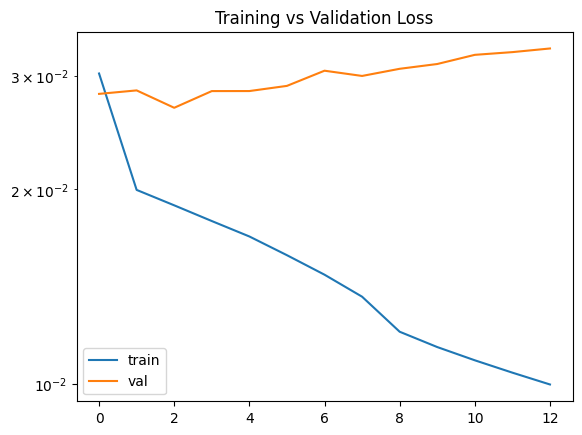

In [97]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.yscale("log")
plt.title("Training vs Validation Loss")
plt.show()


In [98]:
model.save("2ghi_lstm_model.keras")
import joblib

joblib.dump(X_scaler, "X_scaler_2LSTM.pkl")
joblib.dump(y_scaler, "y_scaler_2LSTM.pkl")


['y_scaler_2LSTM.pkl']

In [99]:
# save metadata
import json
with open("2_LSTM_model_metadata.json", "w") as f:
    json.dump({
        "features": features,
        "seq_len": SEQ_LEN,
        "horizon": HORIZON
    }, f, indent=2)


# Inference

In [2]:
%pip install openmeteo-requests
%pip install requests-cache retry-requests numpy pandas

  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
   ---------------------------------------- 0.0/170.8 kB ? eta -:--:--
   --------------------- ------------------ 92.2/170.8 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 170.8/170.8 kB 3.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/684.7 kB ? eta -:--:--
   ------------------------------ -------- 532.5/684.7 kB 11.1 MB/s eta 0:00:01
   --------------------------------------- 684.7/684.7 kB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/144.3 kB ? eta -:--:--
   ---------------------------------------- 144.3/144.3 kB 8.4 MB/s eta 0:00:00
Using cached h11-0.16.0-py3-none-any.whl (37 kB)
   ---------------------------------------- 0.0/246.3 kB ? eta -:--:--
   --------------------------------------- 246.3/246.3 kB 14.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------------------------------------  2.0/2.0 MB 41.


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
   ---------------------------------------- 0.0/61.4 kB ? eta -:--:--
   ---------------------------------------- 61.4/61.4 kB 1.7 MB/s eta 0:00:00
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
   ---------------------------------------- 0.0/70.7 kB ? eta -:--:--
   ---------------------------------------- 70.7/70.7 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1-day future prediction using LSTM

In [8]:
# ============================================================
# 1. Imports
# ============================================================
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
import openmeteo_requests
import requests_cache
from retry_requests import retry
from pvlib.location import Location

# ============================================================
# 2. Solar Feature Function (UNCHANGED from training)
# ============================================================
def add_solar_features_ist(df, lat, lon, altitude=0, tz="Asia/Kolkata"):

    if not isinstance(df.index, pd.DatetimeIndex):
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.set_index("timestamp")

    if df.index.tz is None:
        df.index = df.index.tz_localize(tz)
    else:
        df.index = df.index.tz_convert(tz)

    site = Location(lat, lon, altitude=altitude, tz=tz)

    solpos = site.get_solarposition(df.index)
    df["solar_zenith"] = solpos["apparent_zenith"]
    df["cos_zenith"] = np.cos(np.radians(df["solar_zenith"])).clip(0)

    local_hour = df.index.hour + df.index.minute / 60
    df["hour_sin"] = np.sin(2 * np.pi * local_hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * local_hour / 24)

    df["day_sin"] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df["day_cos"] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

    clearsky = site.get_clearsky(df.index)
    df["clear_ghi"] = clearsky["ghi"]

    df["kt"] = (df["ghi"] / df["clear_ghi"]).replace([np.inf, -np.inf], 0).fillna(0)

    return df

# ============================================================
# 3. Open-Meteo Forecast Fetch Function (MODIFIED)
# ============================================================
def fetch_openmeteo(lat, lon, forecast_days=2):

    cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": [
            "temperature_2m",
            "relative_humidity_2m",
            "wind_speed_10m",
            "wind_direction_10m",
            "surface_pressure",
            "cloud_cover",
            "total_column_integrated_water_vapour",
            "shortwave_radiation",
            "direct_normal_irradiance", 
            "diffuse_radiation"
        ],
        "timezone": "auto",
        "forecast_days": forecast_days
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    timestamps = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )

    df = pd.DataFrame({
        "timestamp": timestamps,
        "temperature": hourly.Variables(0).ValuesAsNumpy(),
        "humidity": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed": hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction": hourly.Variables(3).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(4).ValuesAsNumpy(),
        "cloud_cover": hourly.Variables(5).ValuesAsNumpy(),
        "water_vapour": hourly.Variables(6).ValuesAsNumpy(),
        "ghi": hourly.Variables(7).ValuesAsNumpy(),
        "dni": hourly.Variables(8).ValuesAsNumpy(), 
        "dhi": hourly.Variables(9).ValuesAsNumpy(),
    })

    return df


# ============================================================
# 4. CONFIG
# ============================================================
LAT = 12.9787698
LON = 77.635832

SEQ_LEN = 48
HORIZON = 24

forecast_days=2

FEATURES = [
    "kt",
    "solar_zenith", "cos_zenith",
    "cloud_cover",
    "temperature", "humidity",
    "wind_speed", "surface_pressure",
    "clear_ghi", "wind_direction",
    "water_vapour",
    "dni", "dhi",
    "hour_sin", "hour_cos",
    "day_sin", "day_cos",
    "ghi_clear_weighted"
]

# ============================================================
# 5. LOAD MODEL + SCALERS
# ============================================================
model = load_model("2ghi_lstm_model.keras", compile=False)
X_scaler = joblib.load("X_scaler_2LSTM.pkl")
y_scaler = joblib.load("y_scaler_2LSTM.pkl")

# ============================================================
# 6. FETCH DATA (48h history + 24h future)
# ============================================================
df_raw = fetch_openmeteo(
    LAT, LON,
    forecast_days=forecast_days
)

# ============================================================
# 7. FEATURE ENGINEERING
# ============================================================
df = add_solar_features_ist(df_raw, LAT, LON)

# Clear-sky weighted GHI
df["ghi_clear_weighted"] = df["clear_ghi"] * df["cos_zenith"].clip(0)

# Ensure no NaNs before scaling
df = df.fillna(0)

# ============================================================
# 8. SCALE FEATURES
# ============================================================
X_scaled = X_scaler.transform(df[FEATURES])

# ============================================================
# 9. BUILD INPUT SEQUENCE
# ============================================================
X_input = X_scaled[-SEQ_LEN:]
X_input = X_input.reshape(1, SEQ_LEN, len(FEATURES))

# ============================================================
# 10. PREDICT NEXT 24 HOURS
# ============================================================
y_pred_scaled = model.predict(X_input)

y_pred = y_scaler.inverse_transform(
    y_pred_scaled.reshape(-1, 1)
).flatten()

# ============================================================
# 11. CREATE OUTPUT DATAFRAME
# ============================================================
start_time = df.index[-HORIZON:].min()

timestamps = pd.date_range(
    start=start_time,
    periods=HORIZON,
    freq="H",
    tz="Asia/Kolkata"
)

pred_df = pd.DataFrame({
    "timestamp": timestamps,
    "ghi_pred": y_pred.clip(min=0)
})

# Align prediction timestamps with df index
df_out = df.loc[timestamps].copy()

# Add predicted GHI
df_out["ghi_pred"] = y_pred.clip(min=0)

# Reset index so timestamp is a column
df_out = df_out.reset_index()

df_out.to_csv("30-01-2026.csv", index=False)
print("✅ 24-hour GHI forecast saved: ghi_prediction_24h.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ 24-hour GHI forecast saved: ghi_prediction_24h.csv


C:\Users\sanga\AppData\Local\Temp\ipykernel_16224\3076630738.py:181: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(


In [2]:
pred_df.head(24)

,timestamp,ghi_pred
0,2026-01-22 00:00:00+05:30,0.000000
1,2026-01-22 01:00:00+05:30,0.000000
2,2026-01-22 02:00:00+05:30,0.000000
3,2026-01-22 03:00:00+05:30,0.000000
4,2026-01-22 04:00:00+05:30,0.000000
5,2026-01-22 05:00:00+05:30,0.000000
6,2026-01-22 06:00:00+05:30,0.000000
7,2026-01-22 07:00:00+05:30,45.181671
8,2026-01-22 08:00:00+05:30,224.883911
9,2026-01-22 09:00:00+05:30,510.198273


## - Power calculation

In [ ]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("28-01-2026.csv")

PLANT_CAPACITY_MW = 1.0

PV_AREA = 2.583
NO_PANELS = 1820
TOTAL_PV_AREA = PV_AREA * NO_PANELS

PV_EFFICIENCY = 0.213
DERATE = 0.90

NOCT = 42
TEMP_COEFF = -0.0034

SUN_ELEVATION_LIMIT = 5  # degrees

# Solar elevation
df["solar_elevation"] = 90 - df["solar_zenith"]

# POA irradiance (using predicted GHI)
df["poa_irradiance"] = df["ghi_pred"] * (
    1 + 0.035 * np.sin(np.radians(df["solar_elevation"]))
)

# Sun below horizon → zero
df.loc[
    df["solar_elevation"] < SUN_ELEVATION_LIMIT,
    "poa_irradiance"
] = 0

# Physical cap
df["poa_irradiance"] = df["poa_irradiance"].clip(0, 1100)

# Cell temperature
df["cell_temperature"] = (
    df["temperature"]
    + (NOCT - 20) / 800 * df["poa_irradiance"]
)

# Temperature factor
df["temp_factor"] = (
    1 + TEMP_COEFF * (df["cell_temperature"] - 25)
)

# DC Power (MW)
df["dc_power_mw"] = (
    df["poa_irradiance"]
    * TOTAL_PV_AREA
    * PV_EFFICIENCY
    * df["temp_factor"]
    * DERATE
) / 1e6

# Capacity cap
df["dc_power_mw"] = df["dc_power_mw"].clip(
    lower=0,
    upper=PLANT_CAPACITY_MW
)

# Save CSV
df.to_csv("28-01-2026.csv", index=False)


## Target Date prediction


In [7]:
# ============================================================
# 1. Imports
# ============================================================
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
import openmeteo_requests
import requests_cache
from retry_requests import retry
from pvlib.location import Location

# ============================================================
# 2. Solar Feature Function (UNCHANGED from training)
# ============================================================
def add_solar_features_ist(df, lat, lon, altitude=0, tz="Asia/Kolkata"):

    if not isinstance(df.index, pd.DatetimeIndex):
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.set_index("timestamp")

    if df.index.tz is None:
        df.index = df.index.tz_localize(tz)
    else:
        df.index = df.index.tz_convert(tz)

    site = Location(lat, lon, altitude=altitude, tz=tz)

    solpos = site.get_solarposition(df.index)
    df["solar_zenith"] = solpos["apparent_zenith"]
    df["cos_zenith"] = np.cos(np.radians(df["solar_zenith"])).clip(0)

    local_hour = df.index.hour + df.index.minute / 60
    df["hour_sin"] = np.sin(2 * np.pi * local_hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * local_hour / 24)

    df["day_sin"] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df["day_cos"] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

    clearsky = site.get_clearsky(df.index)
    df["clear_ghi"] = clearsky["ghi"]

    df["kt"] = (df["ghi"] / df["clear_ghi"]).replace([np.inf, -np.inf], 0).fillna(0)

    return df

# ============================================================
# 3. Open-Meteo Forecast Fetch Function (MODIFIED)
# ============================================================
def fetch_openmeteo_custom(lat, lon, start_date, end_date):
    """
    Fetch hourly weather data between start_date and end_date (inclusive)
    Dates must be YYYY-MM-DD
    """

    cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://archive-api.open-meteo.com/v1/archive"

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": [
            "temperature_2m",
            "relative_humidity_2m",
            "wind_speed_10m",
            "wind_direction_10m",
            "surface_pressure",
            "cloud_cover",
            "total_column_integrated_water_vapour",
            "shortwave_radiation",
            "direct_normal_irradiance",
            "diffuse_radiation"
        ],
        "timezone": "Asia/Kolkata"
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    timestamps = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        periods=len(hourly.Variables(0).ValuesAsNumpy()),
        freq="H"
    ).tz_convert("Asia/Kolkata")

    df = pd.DataFrame({
        "timestamp": timestamps,
        "temperature": hourly.Variables(0).ValuesAsNumpy(),
        "humidity": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed": hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction": hourly.Variables(3).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(4).ValuesAsNumpy(),
        "cloud_cover": hourly.Variables(5).ValuesAsNumpy(),
        "water_vapour": hourly.Variables(6).ValuesAsNumpy(),
        "ghi": hourly.Variables(7).ValuesAsNumpy(),
        "dni": hourly.Variables(8).ValuesAsNumpy(),
        "dhi": hourly.Variables(9).ValuesAsNumpy(),
    })

    return df

# ============================================================
# 4. CONFIG
# ============================================================
LAT = 12.9787698
LON = 77.635832

TARGET_DATE = "2026-01-29"
history_start = "2026-01-27"
history_end   = "2026-01-28"


SEQ_LEN = 48
HORIZON = 24

forecast_days=2

FEATURES = [
    "kt",
    "solar_zenith", "cos_zenith",
    "cloud_cover",
    "temperature", "humidity",
    "wind_speed", "surface_pressure",
    "clear_ghi", "wind_direction",
    "water_vapour",
    "dni", "dhi",
    "hour_sin", "hour_cos",
    "day_sin", "day_cos",
    "ghi_clear_weighted"
]

# ============================================================
# 5. LOAD MODEL + SCALERS
# ============================================================
model = load_model("2ghi_lstm_model.keras", compile=False)
X_scaler = joblib.load("X_scaler_2LSTM.pkl")
y_scaler = joblib.load("y_scaler_2LSTM.pkl")

# ============================================================
# 6. FETCH DATA (48h history + 24h future)
# ============================================================
df_raw = fetch_openmeteo_custom(
    LAT, LON,
    start_date=history_start,
    end_date=history_end
)


# ============================================================
# 7. FEATURE ENGINEERING
# ============================================================
df = add_solar_features_ist(df_raw, LAT, LON)

df["ghi_clear_weighted"] = df["clear_ghi"] * df["cos_zenith"].clip(0)
df = df.fillna(0)



df_hist = fetch_openmeteo_custom(
    LAT, LON,
    start_date="2026-01-27",
    end_date="2026-01-28"
)


def fetch_openmeteo_forecast_day(lat, lon, target_date):

    cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": [
            "temperature_2m",
            "relative_humidity_2m",
            "wind_speed_10m",
            "wind_direction_10m",
            "surface_pressure",
            "cloud_cover",
            "total_column_integrated_water_vapour",
            "shortwave_radiation",
            "direct_normal_irradiance",
            "diffuse_radiation"
        ],
        "timezone": "Asia/Kolkata",
        "start_date": target_date,
        "end_date": target_date
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    timestamps = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        periods=len(hourly.Variables(0).ValuesAsNumpy()),
        freq="H"
    ).tz_convert("Asia/Kolkata")

    return pd.DataFrame({
        "timestamp": timestamps,
        "temperature": hourly.Variables(0).ValuesAsNumpy(),
        "humidity": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed": hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction": hourly.Variables(3).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(4).ValuesAsNumpy(),
        "cloud_cover": hourly.Variables(5).ValuesAsNumpy(),
        "water_vapour": hourly.Variables(6).ValuesAsNumpy(),
        "ghi": hourly.Variables(7).ValuesAsNumpy(),
        "dni": hourly.Variables(8).ValuesAsNumpy(),
        "dhi": hourly.Variables(9).ValuesAsNumpy(),
    })



df_hist = add_solar_features_ist(df_hist, LAT, LON)
df_hist["ghi_clear_weighted"] = df_hist["clear_ghi"] * df_hist["cos_zenith"]
df_hist = df_hist.fillna(0)

X_scaled = X_scaler.transform(df_hist[FEATURES])
X_input = X_scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, len(FEATURES))

y_pred = y_scaler.inverse_transform(
    model.predict(X_input).reshape(-1, 1)
).flatten()

df_target = fetch_openmeteo_forecast_day(LAT, LON, TARGET_DATE)
df_target = add_solar_features_ist(df_target, LAT, LON)

df_target["ghi_clear_weighted"] = (
    df_target["clear_ghi"] * df_target["cos_zenith"]
)

df_target = df_target.fillna(0)

df_target["ghi_pred"] = y_pred.clip(min=0)

df_target.reset_index().to_csv(
    "29-01-2026.csv",
    index=False
)

print("✅ Full parameter GHI forecast saved")

C:\Users\sanga\AppData\Local\Temp\ipykernel_16224\3737072687.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(
C:\Users\sanga\AppData\Local\Temp\ipykernel_16224\3737072687.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Full parameter GHI forecast saved


C:\Users\sanga\AppData\Local\Temp\ipykernel_16224\3737072687.py:203: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range(


## Power prediction of tomorrow using LGBM


In [ ]:
import numpy as np
import pandas as pd
import joblib
import openmeteo_requests
import requests_cache
from retry_requests import retry
from pvlib.location import Location

def add_solar_features_ist(df, lat, lon, altitude=0, tz="Asia/Kolkata"):

    if not isinstance(df.index, pd.DatetimeIndex):
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df = df.set_index("timestamp")

    if df.index.tz is None:
        df.index = df.index.tz_localize(tz)
    else:
        df.index = df.index.tz_convert(tz)

    site = Location(lat, lon, altitude=altitude, tz=tz)

    solpos = site.get_solarposition(df.index)
    df["solar_zenith"] = solpos["apparent_zenith"]
    df["cos_zenith"] = np.cos(np.radians(df["solar_zenith"])).clip(0)

    local_hour = df.index.hour + df.index.minute / 60
    df["hour_sin"] = np.sin(2 * np.pi * local_hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * local_hour / 24)

    df["day_sin"] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
    df["day_cos"] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

    clearsky = site.get_clearsky(df.index)
    df["clear_ghi"] = clearsky["ghi"]

    df["kt"] = (df["ghi"] / df["clear_ghi"]).replace(
        [np.inf, -np.inf], 0
    ).fillna(0)

    return df


def fetch_openmeteo_forecast_day(lat, lon, target_date):

    cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    url = "https://api.open-meteo.com/v1/forecast"

    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": [
            "temperature_2m",
            "relative_humidity_2m",
            "wind_speed_10m",
            "wind_direction_10m",
            "surface_pressure",
            "cloud_cover",
            "total_column_integrated_water_vapour",
            "shortwave_radiation",
            "direct_normal_irradiance",
            "diffuse_radiation"
        ],
        "timezone": "Asia/Kolkata",
        "start_date": target_date,
        "end_date": target_date
    }

    response = openmeteo.weather_api(url, params=params)[0]
    hourly = response.Hourly()

    timestamps = pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        periods=len(hourly.Variables(0).ValuesAsNumpy()),
        freq="H"
    ).tz_convert("Asia/Kolkata")

    return pd.DataFrame({
        "timestamp": timestamps,
        "temperature": hourly.Variables(0).ValuesAsNumpy(),
        "humidity": hourly.Variables(1).ValuesAsNumpy(),
        "wind_speed": hourly.Variables(2).ValuesAsNumpy(),
        "wind_direction": hourly.Variables(3).ValuesAsNumpy(),
        "surface_pressure": hourly.Variables(4).ValuesAsNumpy(),
        "cloud_cover": hourly.Variables(5).ValuesAsNumpy(),
        "water_vapour": hourly.Variables(6).ValuesAsNumpy(),
        "ghi": hourly.Variables(7).ValuesAsNumpy(),
        "dni": hourly.Variables(8).ValuesAsNumpy(),
        "dhi": hourly.Variables(9).ValuesAsNumpy(),
    })


LAT = 12.9787698
LON = 77.635832
TARGET_DATE = "2026-01-30"

FEATURES = [
    "kt",
    "solar_zenith", "cos_zenith",
    "cloud_cover",
    "temperature", "humidity",
    "wind_speed", "surface_pressure",
    "clear_ghi", "wind_direction",
    "water_vapour",
    "dni", "dhi",
    "hour_sin", "hour_cos",
    "day_sin", "day_cos",
    "ghi_clear_weighted"
]

ghi_model = joblib.load("Bangalore_ML_model.pkl")

df = fetch_openmeteo_forecast_day(LAT, LON, TARGET_DATE)

df = add_solar_features_ist(df, LAT, LON)

df["ghi_clear_weighted"] = df["clear_ghi"] * df["cos_zenith"]
df = df.fillna(0)


df["ghi_pred"] = ghi_model.predict(df[FEATURES]).clip(min=0)

df.loc[df["cos_zenith"] <= 0, "ghi_pred"] = 0

df.reset_index().to_csv(
    "30-01-2026.csv",
    index=False
)

print("✅ ML-based full-parameter GHI forecast saved")


ModuleNotFoundError: No module named 'pandas'

In [2]:
import openmeteo_requests
import pandas as pd
import requests_cache
from retry_requests import retry

# Setup Open-Meteo client
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# API request
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 10.7905,
    "longitude": 78.7047,
    "start_date": "2014-01-01",
    "end_date": "2025-12-31",
    "hourly": [
        "temperature_2m",
        "relative_humidity_2m",
        "wind_speed_10m",
        "wind_direction_10m",
        "surface_pressure",
        "cloud_cover",
        "total_column_integrated_water_vapour",
        "shortwave_radiation",
        "direct_normal_irradiance",
        "diffuse_radiation",
    ],
    "timezone": "auto",
}

responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# Extract hourly data
hourly = response.Hourly()

hourly_data = {
    "timestamp": pd.date_range(
        start=pd.to_datetime(hourly.Time() + response.UtcOffsetSeconds(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd() + response.UtcOffsetSeconds(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left",
    ),
    "temperature": hourly.Variables(0).ValuesAsNumpy(),
    "humidity": hourly.Variables(1).ValuesAsNumpy(),
    "wind_speed": hourly.Variables(2).ValuesAsNumpy(),
    "wind_direction": hourly.Variables(3).ValuesAsNumpy(),
    "surface_pressure": hourly.Variables(4).ValuesAsNumpy(),
    "cloud_cover": hourly.Variables(5).ValuesAsNumpy(),
    "water_vapour": hourly.Variables(6).ValuesAsNumpy(),
    "ghi": hourly.Variables(7).ValuesAsNumpy(),   # shortwave_radiation
    "dni": hourly.Variables(8).ValuesAsNumpy(),   # direct_normal_irradiance
    "dhi": hourly.Variables(9).ValuesAsNumpy(),   # diffuse_radiation
}

# Create DataFrame
data = pd.DataFrame(hourly_data)

# Remove timezone (optional, cleaner for ML)
data["timestamp"] = data["timestamp"].dt.tz_localize(None)

# Handle missing values (important for solar ML)
data = data.dropna()

# Sort properly
data = data.sort_values("timestamp").reset_index(drop=True)

# Save clean CSV
data.to_csv("Tirchy_Solar_Data.csv", index=False)

print("✅ Perfect CSV Generated Successfully!")
print(data.head())

ModuleNotFoundError: No module named 'openmeteo_requests'